In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
torch.cuda.empty_cache()

transforms = v2.Compose([
    v2.Resize((150,150)),
    v2.Grayscale(),  # Converte para escala de cinza
    v2.RandAugment(10,9),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,),(0.5,)),
])

train_dataset = torchvision.datasets.ImageFolder(root = 'D:\\MGK\\Projetos\\Treino', transform = transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 8, pin_memory = True)

test_dataset = torchvision.datasets.ImageFolder(root= 'D:\\MGK\\Projetos\\Teste', transform=transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 8, pin_memory = True)


classes = ['IA', 'Real']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Printar quantas imagens foram carregadas
print(f'Número de imagens de treino: {len(train_dataset)}')
print(f'Número de imagens de teste: {len(test_dataset)}')

Número de imagens de treino: 8968
Número de imagens de teste: 3840


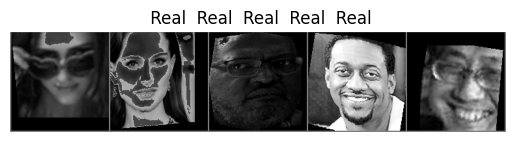

In [2]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Função para mostrar uma imagem
def imshow(img):
    img = img / 2 + 0.5  # desfaz a normalização
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title(' '.join('%5s' % classes[labels[j]] for j in range(5)))
    plt.show()

imshow(torchvision.utils.make_grid(images[0:5]))


In [3]:
# Construir o modelo
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        self.conv4 = nn.Conv2d(128,256,5)
        
        # MaxPooling
        self.maxpool = nn.MaxPool2d(2,2)
        
        # Normalização por batch
        self.bn = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Dropout de neurônios
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256*5*5,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,1)

    def forward(self, x):
        x = self.maxpool(F.relu(self.bn(self.conv1(x))))
        x = self.dropout(x)
        x = self.maxpool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.maxpool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.maxpool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
net = Net().to(device)


In [4]:


# Definir a loss e o otimizador
criterion = nn.BCEWithLogitsLoss()  # Usando BCEWithLogitsLoss para classificação binária
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Treinar a rede
num_epochs = 25
# Treinamento com validação no conjunto de teste
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    # Treinando o modelo
    net.train()  # Modo de treinamento
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()  # Zerar gradientes
        outputs = net(inputs)  # Passar pela rede
        loss = criterion(outputs.view(-1), labels.float())  # Ajustando para BCEWithLogitsLoss
        loss.backward()  # Backpropagation
        optimizer.step()  # Atualizar os pesos
        
        running_loss += loss.item()

        # Calcular acurácia
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Calcular as previsões
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item()

    # Calcular e imprimir a perda média e a acurácia ao final de cada época
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    # Avaliação no conjunto de teste
    net.eval()  # Modo de avaliação
    correct_test = 0
    total_test = 0
    with torch.no_grad():  # Não calcular gradientes para validação
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted.view(-1) == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy (train): {accuracy:.2f}%, Accuracy (test): {test_accuracy:.2f}%')

# Salvar o modelo
torch.save(net.state_dict(), 'D:\\MGK\\Projetos\\modelo.pth')


Epoch 1, Loss: 0.516, Accuracy (train): 73.41%, Accuracy (test): 83.96%
Epoch 2, Loss: 0.263, Accuracy (train): 89.24%, Accuracy (test): 87.71%
Epoch 3, Loss: 0.197, Accuracy (train): 92.31%, Accuracy (test): 89.51%
Epoch 4, Loss: 0.165, Accuracy (train): 93.48%, Accuracy (test): 93.75%
Epoch 5, Loss: 0.158, Accuracy (train): 93.73%, Accuracy (test): 93.23%
Epoch 6, Loss: 0.134, Accuracy (train): 94.97%, Accuracy (test): 90.86%
Epoch 7, Loss: 0.132, Accuracy (train): 95.57%, Accuracy (test): 93.93%
Epoch 8, Loss: 0.138, Accuracy (train): 95.00%, Accuracy (test): 93.88%
Epoch 9, Loss: 0.107, Accuracy (train): 96.18%, Accuracy (test): 95.73%
Epoch 10, Loss: 0.104, Accuracy (train): 96.43%, Accuracy (test): 95.23%
Epoch 11, Loss: 0.092, Accuracy (train): 96.65%, Accuracy (test): 95.78%
Epoch 12, Loss: 0.093, Accuracy (train): 96.81%, Accuracy (test): 97.03%
Epoch 13, Loss: 0.086, Accuracy (train): 96.98%, Accuracy (test): 87.40%
Epoch 14, Loss: 0.077, Accuracy (train): 97.29%, Accuracy (t

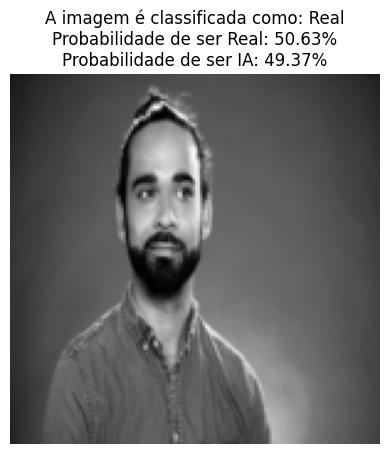

In [14]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import os

# Definir o pipeline de transformações
transformations = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.Grayscale(),  # Converte para escala de cinza
    transforms.ToTensor(),    # Converte para tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normaliza para ter média 0 e desvio 0.5
])

# Função para validar novas imagens e mostrar as porcentagens de cada classe
def validate_new_image(image_path, model, device):
    # Carregar a imagem
    image = Image.open(image_path)
    
    # Aplicar transformações
    image = transformations(image).unsqueeze(0).to(device)  # Adiciona a dimensão do batch
    
    # Colocar o modelo em modo de avaliação
    model.eval()
    
    # Realizar a predição
    with torch.no_grad():  # Desativa o cálculo do gradiente para predição
        output = model(image)
        predicted_prob = torch.sigmoid(output).item()  # Aplica sigmoid e converte para valor numérico
    
    # Calcular as probabilidades de cada classe
    prob_real = predicted_prob * 100  # Probabilidade da classe "Real"
    prob_ia = (1 - predicted_prob) * 100  # Probabilidade da classe "IA"
    
    # Retorna a classe predita e as probabilidades
    if predicted_prob > 0.5:
        predicted_class = "Real"
    else:
        predicted_class = "IA"
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'A imagem é classificada como: {predicted_class}\nProbabilidade de ser Real: {prob_real:.2f}%\nProbabilidade de ser IA: {prob_ia:.2f}%')
    return predicted_class, prob_real, prob_ia

# Carregar o modelo treinado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
model.load_state_dict(torch.load('D:\\MGK\\Projetos\\modelo.pth', weights_only=True))

# Caminho para a nova imagem
image_path = 'D:\\MGK\\Projetos\\Imagens_Para_Validação\\smirking-young-man.jpg'

# Realizar a validação da nova imagem
predicted_class, prob_real, prob_ia = validate_new_image(image_path, model, device)
